In [2]:
import pyscipopt
import numpy as np
import matplotlib.pyplot as plt

## First, create a square

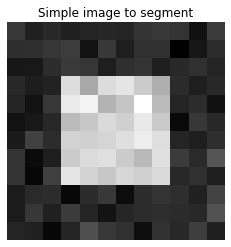

In [18]:
#Make a canvas
H = W = 12
clean_img = np.zeros((W, H), dtype=np.float32)
#Fill in a square!
clean_img[3:-3, 3:-3] = 1.0

img = clean_img + np.random.randn(*clean_img.shape)/10
mn, mx = img.min(), img.max()

# Adjust contrast (equally to both images)
img = (img - mn) / (mx - mn)

plt.imshow(img,cmap='gray')
plt.axis('off')
plt.title('Simple image to segment');

In [10]:
m = pyscipopt.Model()

In [11]:
#Create the list of variables


#Create px_i
px = {}
for i in range(W):
    px[i] = m.addVar(f'Px_{i}',vtype = 'B')
#Create py_i
py = {}
for i in range(H):
    py[i] = m.addVar(f'Py_{i}',vtype = 'B')

#Create Hx_i    
hx = {}
for i in range(W):
    hx[i] = m.addVar(f'Hx_{i}',vtype = 'B')
#Create Hy_i
hy = {}
for i in range(H):
    hy[i] = m.addVar(f'Hy_{i}',vtype = 'B')
    
#Create H_ij
h = {}
for i in range(W):
    for j in range(H):
        h[i,j] = m.addVar(f'H_{i},{j}',vtype = 'B')

In [12]:
##This seemed faster when they were not booleans???

#Add linear constraints
# only 2 Px
m.addCons(pyscipopt.quicksum(px[i] for i in range(W)) == 2)
# only 2 Py
m.addCons(pyscipopt.quicksum(py[i] for i in range(H)) == 2)

#Add nonlinear constraints
#(-Hx_i + 1/2) * prod_j^W(i - Px_j *j) >0
for i in range(W):
    m.addCons((-hx[i] + .5) * pyscipopt.quickprod(i - px[j]*j for j in range(W)) >= 0)
#(-Hy_i + 1/2) * prod_j^W(i - Py_j *j) >0
for i in range(H):
    m.addCons((-hx[i] + .5) * pyscipopt.quickprod(i - py[j]*j for j in range(W)) >= 0)
    
# Set Hij matrix
for i in range(W):
    for j in range(H):
        m.addCons(h[i,j] == hx[i]*hy[j])

In [13]:
# Define objective
color_1 = 1
color_2 = 0
c1_f = (color_1-img)**2
c2_f = (color_2 - img)**2

obj = pyscipopt.quicksum(c1_f[i,j]*h[i,j] + c2_f[i,j]*(1-h[i,j]) for i in range(W) for j in range(H))
m.setObjective(obj,sense='minimize')

In [14]:
m.optimize()

presolving:
(round 1, fast)       0 del vars, 2 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 0 upgd conss, 0 impls, 0 clqs
(round 2, exhaustive) 0 del vars, 2 del conss, 49250 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 166 upgd conss, 0 impls, 0 clqs
(round 3, fast)       144 del vars, 146 del conss, 49250 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 166 upgd conss, 0 impls, 720 clqs
   (4.1s) symmetry computation started: requiring (bin +, int -, cont +), (fixed: bin -, int +, cont -)
   (4.7s) no symmetry present
   (4.7s) symmetry computation started: requiring (bin +, int +, cont +), (fixed: bin -, int -, cont -)
   (5.3s) no symmetry present
presolving (4 rounds: 4 fast, 2 medium, 2 exhaustive):
 169 deleted vars, 146 deleted constraints, 49250 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 720 cliques
presolved problem has 49273 variables (192 bin, 0 int, 49081 impl, 0 cont) and 49

In [15]:
m.getStatus()

'optimal'

In [16]:
print('x coordinates \n -------------------------')
for i in range(W):
    if m.getVal(px[i]) == 1:
        print(i)
        
print('y coordinates \n -------------------------')
for i in range(H):
    if m.getVal(py[i]) == 1:
        print(i)
        
H_mat = np.zeros([W,H])
for i in range(W):
    for j in range(H):
        if m.getVal(h[i,j]) == 1:
            H_mat[i,j] = 1

x coordinates 
 -------------------------
2
9
y coordinates 
 -------------------------
2
9


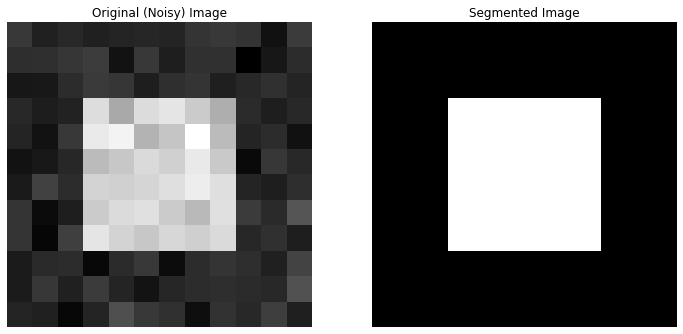

In [25]:
plt.figure(figsize=[12,12])
plt.subplot(121)
plt.imshow(img,cmap='gray')
plt.title('Original (Noisy) Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(H_mat,cmap='gray')
plt.title('Segmented Image')
plt.axis('off')

plt.savefig('NoisySquareOptim.png')

In [26]:
np.random.get_state()

('MT19937',
 array([1601512086,  317939758, 2033672481, 4203621070, 3660221724,
        1883402280, 3407779416, 3817390263, 1014139561, 1719791262,
        3632328653, 2032072594, 4085505603, 2766811646,  738259560,
        3064831008,  222831199, 3655283991, 1324397846,  959171870,
         300516757, 1241902648,  116700567, 3374217270,  712938442,
        3933607264,  175543296,   41853819, 1339688288, 2080754266,
        2570574833, 1927289837, 2466538498, 2658887588, 3752773050,
         746491787, 3938301401, 3385527967, 4165099409, 2380270644,
        3324220321,  565505952,  809789852,  725481434, 1237401009,
        2365206030, 2416565027, 4148372366, 3104132213, 1115283206,
        3428478155, 3873805511, 3764161337, 3226613747, 3358611187,
        3879800041, 2227541213, 2846567606,  364536242, 3819836405,
        2777649234, 4004860746,  300281987,  638612163, 2338575810,
        1867935189, 3852426974,   24438077, 2172778944, 4089573961,
        2436704507, 3240148138,  666